# LangGraph Tutorials
https://langchain-ai.github.io/langgraph/tutorials/get-started

## Build the chatbot

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [5]:
import os
from langchain.chat_models import init_chat_model

# Load .env
from dotenv import load_dotenv
load_dotenv()

llm = init_chat_model(
    "openai:glm-4-plus",
    base_url="https://open.bigmodel.cn/api/paas/v4"
)

In [6]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [7]:
graph_builder.add_edge(START, "chatbot")

In [8]:
graph = graph_builder.compile()

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Run the chatbot

In [10]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: It seems like you've entered "Test." If you're checking to see if the system is working, yes, it is! How can I assist you today? If you have any specific questions or need information on a particular topic, feel free to ask!
Goodbye!


## Tool

In [11]:
from langchain_tavily import TavilySearch

from dotenv import load_dotenv
load_dotenv()

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://medium.com/@vivekvjnk/langgraph-basics-understanding-state-schema-nodes-and-edges-77f2fd17cae5',
   'title': 'LangGraph Basics: Understanding State, Schema, Nodes, and Edges',
   'content': 'Nodes: Perform the actual work. Nodes contain Python code that can execute any logic, from simple computations to LLM calls or integrations.',
   'score': 0.79254496,
   'raw_content': None},
  {'url': 'https://blog.langchain.dev/langgraph/',
   'title': 'LangGraph - LangChain Blog',
   'content': "TL;DR: LangGraph is module built on top of LangChain to better enable creation of cyclical graphs, often needed for agent runtimes. This state is updated by nodes in the graph, which return operations to attributes of this state (in the form of a key-value store). After adding nodes, you can then add edges to create the graph. An example of this may be in the basic agent 

In [12]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    "openai:glm-4-plus",
    base_url="https://open.bigmodel.cn/api/paas/v4"
)

llm_with_tools = llm.bind_tools(tools)

def chatbot_with_tools(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot_with_tools", chatbot_with_tools)

In [13]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [14]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools_with_tools", tool_node)

In [15]:
from langgraph.graph import StateGraph, START, END

def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools_with_tools"
    return END

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_edge(START, "chatbot_with_tools")
graph_builder.add_conditional_edges(
    "chatbot_with_tools",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools_with_tools": "tools_with_tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools_with_tools", "chatbot_with_tools")
graph = graph_builder.compile()

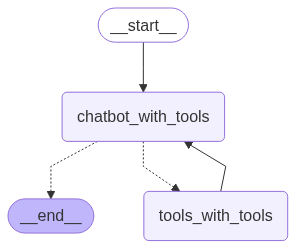

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I assist you today? If you have any questions or need information on a specific topic, feel free to ask!
Goodbye!


## Memory

In [18]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [19]:
graph = graph_builder.compile(checkpointer=memory)

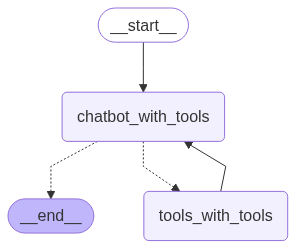

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
config = {"configurable": {"thread_id": "1"}}

In [22]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I assist you today? If you have any questions or need information on a specific topic, feel free to ask!


In [23]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course, I remember your name is Will! How can I help you today? If you have any questions or need assistance with something, just let me know!


In [24]:
# Different config
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course! You're [Your Name]. How can I assist you today? If you have any specific questions or need information on a particular topic, feel free to let me know!


In [25]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='21561868-8b88-4123-80c2-eca01cbb00b0'), AIMessage(content='Hello Will! How can I assist you today? If you have any questions or need information on a specific topic, feel free to ask!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 1262, 'total_tokens': 1292}, 'model_name': 'glm-4-plus', 'system_fingerprint': None, 'id': '20250721205040107e330c3e2f469c', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--38de0b77-b6ed-4d56-93a7-86a888abd9aa-0', usage_metadata={'input_tokens': 1262, 'output_tokens': 30, 'total_tokens': 1292, 'input_token_details': {}, 'output_token_details': {}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='ea7725a2-266b-4e74-9f57-72746a62b649'), AIMessage(content='Of course, I remember your name is Will! How can I he

In [26]:
snapshot.next # END

()

## Human-in-the-loop

In [27]:
import os
from langchain.chat_models import init_chat_model

# Load .env
from dotenv import load_dotenv
load_dotenv()

llm = init_chat_model(
    "openai:glm-4-plus",
    base_url="https://open.bigmodel.cn/api/paas/v4"
)

In [28]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

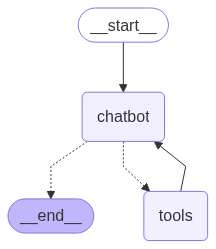

In [ ]:
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

# Agent design for DataGPT

In [66]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [67]:
from langchain_tavily import TavilySearch

from dotenv import load_dotenv
load_dotenv()

what_question_tool = TavilySearch(max_results=2)
why_question_tool = TavilySearch(max_results=2)
tools = [what_question_tool, why_question_tool]

In [118]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    "openai:glm-4-plus",
    base_url="https://open.bigmodel.cn/api/paas/v4"
)

llm_with_tools = llm.bind_tools(tools)

def chatbot_with_tools(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("coordinator", chatbot)
graph_builder.add_node("planner", chatbot)
graph_builder.add_node("greeter", chatbot)
graph_builder.add_node("supervisor", chatbot)
graph_builder.add_node("reporter", chatbot)
graph_builder.add_node("single_question_expert", chatbot_with_tools)

In [119]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("question_tools", tool_node)

In [ ]:
from typing import Literal

def coordinate(state) -> Literal["greeter", "planner"]:
    pass

def plan(state) -> Literal["supervisor", "end"]:
    pass

def supervise(state) -> Literal["single_question_expert", "end"]:
    pass

def single_question_expertize(state) -> Literal["question_tools", "supervisor"]:
    pass


graph_builder.add_edge(START, "coordinator")
graph_builder.add_conditional_edges(
    "coordinator",
    coordinate,
    {"greeter": "greeter", "planner": "planner"},
)
graph_builder.add_conditional_edges(
    "planner",
    plan,
    {"supervisor": "supervisor", "end": END},
)
graph_builder.add_conditional_edges(
    "supervisor",
    supervise,
    {"single_question_expert": "single_question_expert", "reporter": "reporter", "end": END},
)
graph_builder.add_conditional_edges(
    "single_question_expert",
    single_question_expertize,
    {"question_tools": "question_tools", "supervisor": "supervisor"},
)

graph_builder.add_edge("question_tools", "single_question_expert")
graph_builder.add_edge("reporter", "supervisor")


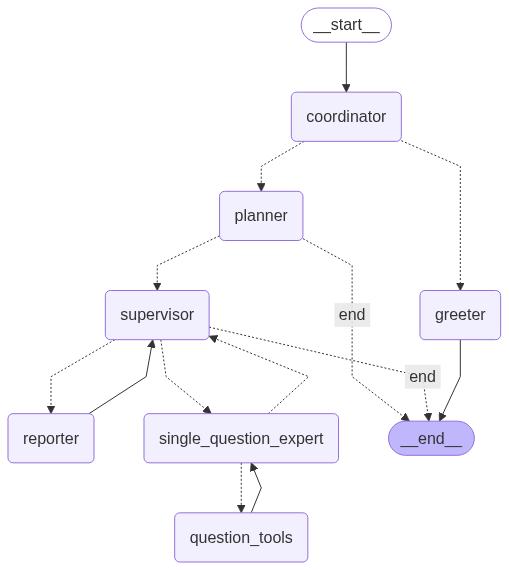

In [121]:
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))